In [1]:
#Importing Libraries
import pandas as pd
import numpy as np
import scipy as sci
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.feature_extraction.text import CountVectorizer

import re, nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
wordnet_lemmatizer = WordNetLemmatizer()

In [2]:
train_set = pd.read_excel('data/回归/train.xlsx')
test_set = pd.read_excel('data/回归/testStudent.xlsx')

In [3]:
train_set.shape, test_set.shape

((80000, 8), (30000, 7))

In [4]:
data_set = pd.concat([train_set, test_set], sort=False, axis=0)
# data_set = train_set

In [5]:
data = data_set

In [6]:
data.shape

(110000, 8)

In [7]:
tags = data["Tags"]
del data["Tags"]

## Mining some important information from tags

# 1、Leisure or business

In [8]:
data['Leisure'] = tags.map(lambda x: 1 if ' Leisure trip ' in x else 0)
data['Business'] = tags.map(lambda x: 2 if ' Business trip ' in x else 0)
data['Trip_type'] = data['Leisure'] + data['Business']
del data['Leisure']
del data['Business']

In [9]:
data['Trip_type'].value_counts()

1    89061
2    17696
0     3243
Name: Trip_type, dtype: int64

# 2、How many people

In [10]:
#Couple or Solo or Group or Family_with_older children or Family with younger Children
data['Solo'] = tags.map(lambda x: 1 if ' Solo traveler ' in x else 0)
data['Couple'] = tags.map(lambda x: 2 if ' Couple ' in x else 0)
data['Family_with_young_children'] = tags.map(lambda x: 3 if ' Family with young children ' in x else 0)
data['Family_with_older_children'] = tags.map(lambda x: 4 if ' Family with older children ' in x else 0)
data['Group'] = tags.map(lambda x: 5 if ' Group ' in x else 0)
data['whom'] = data['Solo'] + data['Couple'] + data['Group'] + data['Family_with_young_children'] + data['Family_with_older_children']
del data['Solo'], data['Couple'],data['Group'], data['Family_with_young_children'],data['Family_with_older_children']

In [11]:
data.whom.value_counts()

2    53985
1    23089
5    13791
3    13078
4     5562
0      495
Name: whom, dtype: int64

In [12]:
#I will assign 2 to 0's because it is the most.
data['whom'] = data['whom'].map(lambda x: 2 if x == 0 else x)
data.whom.value_counts()

2    54480
1    23089
5    13791
3    13078
4     5562
Name: whom, dtype: int64

In [13]:
data.head()

,Additional_Number_of_Scoring,Average_Score,Review_Total_Negative_Word_Counts,Total_Number_of_Reviews,Review_Total_Positive_Word_Counts,Total_Number_of_Reviews_Reviewer_Has_Given,Reviewer_Score,Trip_type,whom
0,255,8.1,57,1290,10,1,6.3,0,3
1,211,8.6,0,2923,19,12,10.0,1,3
2,189,9.2,27,781,29,24,10.0,2,2
3,1258,9.4,20,4204,31,3,9.2,1,2
4,289,8.8,0,1519,3,9,10.0,1,1


# 3、what kind of room

In [14]:
# Queen Room两张单人床
scale_of_room = {'Double': 2, 'Single': 1, 'Twin': 2,
                  'Triple': 3, 'Quadruple': 4, 'Queen': 2, 
                  'King': 2, 'Suite': 2, 'Studio': 3, 'Executive': 4
                }
level_of_room = {'Standard': 1, 'Superior': 6, 'Deluxe': 7, 'Classic': 2, 'Premium': -3,
                 'Small': 0.5, 'Quality': 5, 'Wonderful': 6, 'Compact': 1, 'Comfort': 3, 
                 'Large': 3, 'Privilege': 5, 'Cosy': -2, 'Art': 4, 'Junior': 6, 'Garden': 5, 'Basic': 1
                }

def get_weight(tag):
    weight = 0
    for room, scale in scale_of_room.items():
        if room in tag:
            rate = 1
            for level, level_w in level_of_room.items():
                if level in tag:
                    rate = level_w
                    if "Room with" in tag:
                        rate += 1
                    break
            weight += scale * rate
    return weight
data['room'] = tags.map(lambda x: get_weight(x))

In [15]:
data.room.value_counts()

 2.0     33888
 4.0     18224
 12.0    12978
 0.0     10601
 14.0     9817
 1.0      4978
 6.0      4570
 24.0     3916
 28.0     2210
 8.0      2057
 3.0      1918
 16.0      931
 7.0       908
 5.0       742
-4.0       374
 21.0      344
 18.0      265
-12.0      193
 32.0      176
 10.0      156
-6.0       145
 9.0       115
-2.0       108
 20.0       87
 35.0       69
 0.5        58
 30.0       53
 36.0       38
-8.0        20
 1.5        15
 15.0       12
-9.0        10
 63.0        8
 48.0        7
 42.0        7
 49.0        2
Name: room, dtype: int64

In [16]:
data.head()

,Additional_Number_of_Scoring,Average_Score,Review_Total_Negative_Word_Counts,Total_Number_of_Reviews,Review_Total_Positive_Word_Counts,Total_Number_of_Reviews_Reviewer_Has_Given,Reviewer_Score,Trip_type,whom,room
0,255,8.1,57,1290,10,1,6.3,0,3,2.0
1,211,8.6,0,2923,19,12,10.0,1,3,2.0
2,189,9.2,27,781,29,24,10.0,2,2,0.0
3,1258,9.4,20,4204,31,3,9.2,1,2,16.0
4,289,8.8,0,1519,3,9,10.0,1,1,7.0


# 4、stay n days

In [17]:
#Stayings
data['Stayed_1_days'] = tags.map(lambda x: 1 if ' Stayed 1 night ' in x else 0)
data['Stayed_2_days'] = tags.map(lambda x: 2 if ' Stayed 2 nights ' in x else 0)
data['Stayed_3_days'] = tags.map(lambda x: 3 if ' Stayed 3 nights ' in x else 0)
data['Stayed_4_days'] = tags.map(lambda x: 4 if ' Stayed 4 nights ' in x else 0)
data['Stayed_5_days'] = tags.map(lambda x: 5 if ' Stayed 5 nights ' in x else 0)
data['Stayed_6_days'] = tags.map(lambda x: 6 if ' Stayed 6 nights ' in x else 0)
data['Stayed_7_days'] = tags.map(lambda x: 7 if ' Stayed 7 nights ' in x else 0)
data['Stayed_8_days'] = tags.map(lambda x: 8 if ' Stayed 8 nights ' in x else 0)
data['Stayed_9_days'] = tags.map(lambda x: 9 if ' Stayed 9 nights ' in x else 0)
data['Stayed_10_days'] = tags.map(lambda x: 10 if ' Stayed 10 nights ' in x else 0)
data['Stayed_11_days'] = tags.map(lambda x: 11 if ' Stayed 11 nights ' in x else 0)
data['Stayed_12_days'] = tags.map(lambda x: 12 if ' Stayed 12 nights ' in x else 0)
data['Stayed_13_days'] = tags.map(lambda x: 13 if ' Stayed 13 nights ' in x else 0)
data['Stayed_14_days'] = tags.map(lambda x: 14 if ' Stayed 14 nights ' in x else 0)
data['Stayed_15_days'] = tags.map(lambda x: 15 if ' Stayed 15 nights ' in x else 0)
data['Stayed_16_days'] = tags.map(lambda x: 16 if ' Stayed 16 nights ' in x else 0)
data['Stayed_17_days'] = tags.map(lambda x: 17 if ' Stayed 17 nights ' in x else 0)
data['Stayed_18_days'] = tags.map(lambda x: 18 if ' Stayed 18 nights ' in x else 0)
data['Stayed_19_days'] = tags.map(lambda x: 19 if ' Stayed 19 nights ' in x else 0)
data['Stayed_20_days'] = tags.map(lambda x: 20 if ' Stayed 20 nights ' in x else 0)

In [18]:
temp_list = []
for j in range(9,28):
    sum = np.sum(data.iloc[:,j])/(j-8)
    temp_list.append(sum)

In [19]:
staying = np.array(temp_list,dtype=int)
np.sum(staying)

764217

In [22]:
data['stayed_days'] = data['Stayed_1_days'] + data['Stayed_2_days'] + data['Stayed_3_days'] + data['Stayed_4_days'] + data['Stayed_5_days'] + data['Stayed_6_days'] + data['Stayed_7_days'] + data['Stayed_8_days'] + data['Stayed_9_days'] + data['Stayed_10_days'] + data['Stayed_11_days'] + data['Stayed_12_days'] + data['Stayed_13_days'] + data['Stayed_14_days'] + data['Stayed_15_days'] + data['Stayed_16_days'] + data['Stayed_17_days'] + data['Stayed_18_days'] + data['Stayed_19_days'] + data['Stayed_20_days']
del data['Stayed_1_days'] , data['Stayed_2_days'] , data['Stayed_3_days'] , data['Stayed_4_days'], data['Stayed_5_days'] , data['Stayed_6_days'] , data['Stayed_7_days'] , data['Stayed_8_days'] , data['Stayed_9_days'] , data['Stayed_10_days'] , data['Stayed_11_days'] , data['Stayed_12_days'] , data['Stayed_13_days'] , data['Stayed_14_days'] , data['Stayed_15_days'] , data['Stayed_16_days'] , data['Stayed_17_days'] , data['Stayed_18_days'] , data['Stayed_19_days'] , data['Stayed_20_days']

In [23]:
data['stayed_days'] = data['stayed_days'].map(lambda x: 21 if x == 0 else x)

In [24]:
data.stayed_days.value_counts()

1     41088
2     28637
3     20505
4     10234
5      4472
6      2050
7      1602
8       547
9       283
10      194
11       90
12       70
21       64
13       53
14       53
15       24
17       11
16        9
19        6
18        5
20        3
Name: stayed_days, dtype: int64

In [25]:
data.head()

,Additional_Number_of_Scoring,Average_Score,Review_Total_Negative_Word_Counts,Total_Number_of_Reviews,Review_Total_Positive_Word_Counts,Total_Number_of_Reviews_Reviewer_Has_Given,Reviewer_Score,Trip_type,whom,room,stayed_days
0,255,8.1,57,1290,10,1,6.3,0,3,2.0,1
1,211,8.6,0,2923,19,12,10.0,1,3,2.0,5
2,189,9.2,27,781,29,24,10.0,2,2,0.0,1
3,1258,9.4,20,4204,31,3,9.2,1,2,16.0,1
4,289,8.8,0,1519,3,9,10.0,1,1,7.0,1


# 5、submitted by mobile device?

In [26]:
#Mobile device
data['mobile_device'] = tags.map(lambda x: 1 if ' Submitted from a mobile device ' in x else 0)

In [27]:
data.head()

,Additional_Number_of_Scoring,Average_Score,Review_Total_Negative_Word_Counts,Total_Number_of_Reviews,Review_Total_Positive_Word_Counts,Total_Number_of_Reviews_Reviewer_Has_Given,Reviewer_Score,Trip_type,whom,room,stayed_days,mobile_device
0,255,8.1,57,1290,10,1,6.3,0,3,2.0,1,0
1,211,8.6,0,2923,19,12,10.0,1,3,2.0,5,1
2,189,9.2,27,781,29,24,10.0,2,2,0.0,1,0
3,1258,9.4,20,4204,31,3,9.2,1,2,16.0,1,1
4,289,8.8,0,1519,3,9,10.0,1,1,7.0,1,0


# 6、tag分析

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20]), <a list of 21 Text xticklabel objects>)

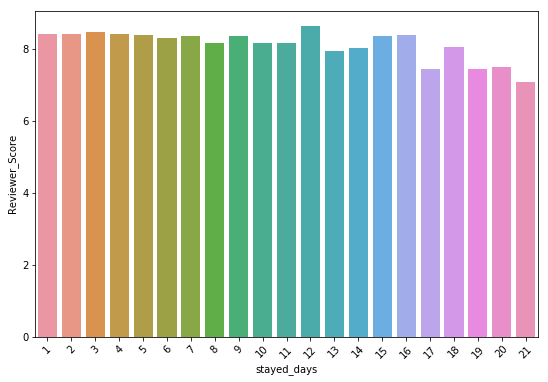

In [54]:
## Stayed_days
stayed_days_hist=data.groupby("stayed_days")['Reviewer_Score'].mean().reset_index().sort_values(by='stayed_days',ascending=False).reset_index(drop=True)
plt.figure(figsize=(9,6))
sns.barplot(x='stayed_days',y='Reviewer_Score', data=stayed_days_hist)
plt.xticks(rotation=45)

#According to General trend , the more the staying , the less the reviewer_score .

(array([0, 1, 2, 3, 4]), <a list of 5 Text xticklabel objects>)

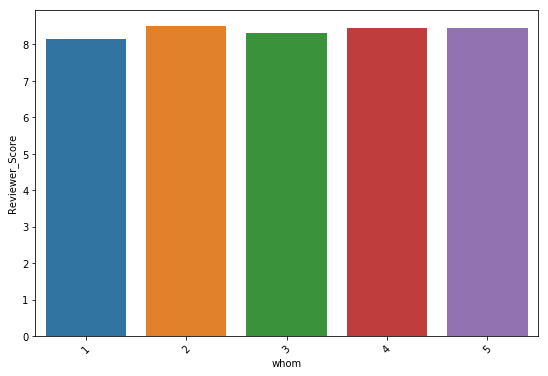

In [55]:
#Whom
whom_hist=data.groupby("whom")['Reviewer_Score'].mean().reset_index().sort_values(by='whom',ascending=False).reset_index(drop=True)
plt.figure(figsize=(9,6))
sns.barplot(x='whom',y='Reviewer_Score', data=whom_hist)
plt.xticks(rotation=45)

#This attribute doens't look so important .

Text(0.5, 1.0, 'Mobile Device')

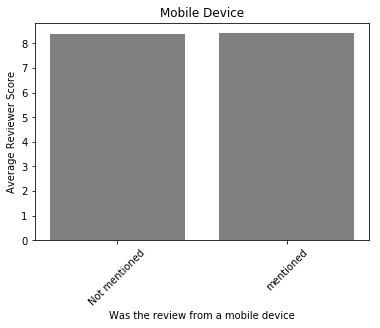

In [24]:
##Mobile Device
md_avg=data.groupby('mobile_device')['Reviewer_Score'].mean()
Index = [0,1]
plt.bar(Index,md_avg,color='gray')
plt.xticks(Index,['Not mentioned','mentioned'],rotation=45)
plt.ylabel('Average Reviewer Score')
plt.xlabel('Was the review from a mobile device')
plt.title('Mobile Device')

#Mobile_device parameter isn't  important

Text(0.5, 1.0, 'Trip Type')

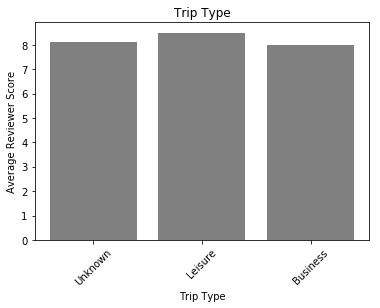

In [58]:
##Trip Type
tt_avg=data.groupby('Trip_type')['Reviewer_Score'].mean()
Index = [0,1,2]
plt.bar(Index,tt_avg,color='gray')
plt.xticks(Index,['Unknown', 'Leisure','Business'],rotation=45)
plt.ylabel('Average Reviewer Score')
plt.xlabel('Trip Type')
plt.title('Trip Type')

#Business type of trips are rating lower .
# Trip_type parameter is important

In [59]:
data.head()

,Additional_Number_of_Scoring,Average_Score,Review_Total_Negative_Word_Counts,Total_Number_of_Reviews,Review_Total_Positive_Word_Counts,Total_Number_of_Reviews_Reviewer_Has_Given,Reviewer_Score,Trip_type,whom,room,stayed_days
0,255,8.1,57,1290,10,1,6.3,0,3,2.0,1
1,211,8.6,0,2923,19,12,10.0,1,3,2.0,5
2,189,9.2,27,781,29,24,10.0,2,2,0.0,1
3,1258,9.4,20,4204,31,3,9.2,1,2,16.0,1
4,289,8.8,0,1519,3,9,10.0,1,1,7.0,1


In [59]:
#Correlation Matrix:
# corr_df = data[data.keys()]    
# corr_df = corr_df.corr()
corr_df = data.corrwith(data.Reviewer_Score)

In [65]:
with open("result.csv", 'w') as f:
    for k, v in corr_df.items():
        if k == "Reviewer_Score":
            continue
        if v < 0:
            v = -v
        print(k, v, file=f, sep=',')

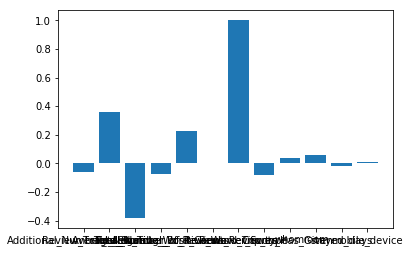

In [57]:
fig=plt.figure()
ax1=plt.subplot(111)
ax1.bar(corr_df.keys(), corr_df.values)
ax1.set_xticks(tuple(corr_df.keys()))
# Set up the matplot figure
# f,ax = plt.subplots(figsize=(1,12))

#Draw the heatmap using seaborn
# sns.heatmap(corr_df, cmap='inferno', annot=True)

#Reviewer_Score may have correlations with Average_Score ,Review_Total_Negative_Word_Counts ,Review_Total_Positive_Word_Counts 

# 测试

In [39]:
label = data['Reviewer_Score']
del data['Reviewer_Score']

In [40]:
dataset_X = data.iloc[:].values

In [41]:
dataset_X.shape

(110000, 10)

In [56]:
X = dataset_X[:80000]
X_test = dataset_X[80000:]
y = label.values[:80000]

In [43]:
X.shape, y.shape, X_test.shape

((80000, 10), (80000,), (30000, 10))

In [44]:
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from importlib import reload
import ensemble.gbdt_model
reload(ensemble.gbdt_model)
from ensemble.gbdt_model import GBDTRegressor

In [45]:
def corrcoef(y_true, y_pred):
    return np.corrcoef(y_true, y_pred)[0][1]

# 1、sklearn GBDT

In [47]:
cross_val_score(GradientBoostingRegressor(n_estimators=100, learning_rate=0.15, max_depth=3),
               X, y, scoring=make_scorer(corrcoef), cv=5).mean()     # 无tag

0.6540990128659783

In [126]:
cross_val_score(GradientBoostingRegressor(n_estimators=300, learning_rate=0.065, max_depth=3),
               X, y, scoring=make_scorer(corrcoef), cv=5).mean()     # 不删tag

0.6574295848725024

In [133]:
cross_val_score(GradientBoostingRegressor(n_estimators=300, learning_rate=0.065, max_depth=3),
               X, y, scoring=make_scorer(corrcoef), cv=5).mean()     # 删mobile device

0.6574523502871455

In [140]:
cross_val_score(GradientBoostingRegressor(n_estimators=300, learning_rate=0.065, max_depth=3),
               X, y, scoring=make_scorer(corrcoef), cv=5).mean()     # 删mobile device+total given

0.6572021265507566

In [146]:
cross_val_score(GradientBoostingRegressor(n_estimators=300, learning_rate=0.065, max_depth=3),
               X, y, scoring=make_scorer(corrcoef), cv=5).mean()     # 删mobile device+stayed days

0.6573088858494304

In [46]:
cross_val_score(GradientBoostingRegressor(n_estimators=300, learning_rate=0.065, max_depth=3),
               X, y, scoring=make_scorer(corrcoef), cv=5).mean()     # 删mobile device，增加room

0.65746407714058

In [106]:
cross_val_score(GradientBoostingRegressor(n_estimators=100, learning_rate=0.15, max_depth=3),
               X, y, scoring=make_scorer(corrcoef), cv=5).mean()     # 处理tag

0.6560911111759332

In [118]:
cross_val_score(GradientBoostingRegressor(n_estimators=200, learning_rate=0.1, max_depth=3),
               X, y, scoring=make_scorer(corrcoef), cv=5).mean()     # 处理tag

0.6561783365872857

In [125]:
cross_val_score(GradientBoostingRegressor(n_estimators=150, learning_rate=0.1, max_depth=3),
               X, y, scoring=make_scorer(corrcoef), cv=5).mean()     # 处理tag

0.6560700349345118

In [149]:
cross_val_score(GradientBoostingRegressor(n_estimators=250, learning_rate=0.065, max_depth=3),
               X, y, scoring=make_scorer(corrcoef), cv=5).mean()     # 处理tag

0.6565681831878003

In [150]:
cross_val_score(GradientBoostingRegressor(n_estimators=300, learning_rate=0.065, max_depth=3),
               X, y, scoring=make_scorer(corrcoef), cv=5).mean()     # 处理tag

0.6565732289877209

In [155]:
cross_val_score(GradientBoostingRegressor(n_estimators=400, learning_rate=0.04, max_depth=3),
               X, y, scoring=make_scorer(corrcoef), cv=5).mean()     # 处理tag

0.6565323333429586

# 2、GDBTRegressor

In [180]:
cross_val_score(GBDTRegressor(n_estimators=250, learning_rate=0.065, max_depth=3),
               X, y, scoring=make_scorer(corrcoef), cv=5).mean()     # 处理tag(my gbdt+sklearn cart)

0.656608553077634

In [48]:
cross_val_score(GBDTRegressor(n_estimators=300, learning_rate=0.065, max_depth=3),
               X, y, scoring=make_scorer(corrcoef), cv=5).mean()     # 删mobile device，增加room(my gbdt+our cart)

Training: 100% [------------------------------------------------] Time: 0:04:38
Training: 100% [------------------------------------------------] Time: 0:04:50
Training: 100% [------------------------------------------------] Time: 0:04:30
Training: 100% [------------------------------------------------] Time: 0:04:33
Training: 100% [------------------------------------------------] Time: 0:04:22


0.6566333967894796

In [50]:
reg = GBDTRegressor(n_estimators=300, learning_rate=0.065, max_depth=3)
reg.fit(X, y)

Training: 100% [------------------------------------------------] Time: 0:05:15


In [52]:
y_pred = reg.predict(X_test)
with open("16337091_0.txt", 'w', encoding='utf-8') as f:
    for yi in y_pred:
        print(yi, file=f)

In [184]:
cross_val_score(GBDTRegressor(n_estimators=250, learning_rate=0.065, max_depth=3),
               X, y, scoring=make_scorer(corrcoef), cv=5).mean()     # 处理tag(my gbdt+dirun cart)

Training: 100% [------------------------------------------------] Time: 0:01:38
Training: 100% [------------------------------------------------] Time: 0:01:40
Training: 100% [------------------------------------------------] Time: 0:01:38
Training: 100% [------------------------------------------------] Time: 0:01:40
Training: 100% [------------------------------------------------] Time: 0:01:57


0.6555628336568144

In [185]:
cross_val_score(GBDTRegressor(n_estimators=100, learning_rate=0.15, max_depth=3),
               X, y, scoring=make_scorer(corrcoef), cv=5).mean()     # 处理tag(my gbdt+dirun cart)

Training: 100% [------------------------------------------------] Time: 0:01:20
Training: 100% [------------------------------------------------] Time: 0:01:30
Training: 100% [------------------------------------------------] Time: 0:01:31
Training: 100% [------------------------------------------------] Time: 0:02:01
Training: 100% [------------------------------------------------] Time: 0:02:23


0.6550656097031883

# 3、随机森林

In [53]:
from sklearn.ensemble import RandomForestRegressor

In [57]:
X.shape, y.shape

((80000, 10), (80000,))

In [59]:
cross_val_score(RandomForestRegressor(n_estimators=300), X, y, scoring=make_scorer(corrcoef), cv=5).mean()

0.6258552484503783

In [78]:
import decision_tree.decision_tree
reload(decision_tree.decision_tree)
import ensemble.random_forest
reload(ensemble.random_forest)
from ensemble.random_forest import RandomForest

In [79]:
cross_val_score(RandomForest(), X, y, scoring=make_scorer(corrcoef), cv=5).mean()

Training: 100% [------------------------------------------------] Time: 0:02:44
Training: 100% [------------------------------------------------] Time: 0:03:05
Training: 100% [------------------------------------------------] Time: 0:02:59
Training: 100% [------------------------------------------------] Time: 0:03:33
Training: 100% [------------------------------------------------] Time: 0:03:29


0.6532569990118839